# Projet

## Basic test

### Importations

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
C01 = netCDF4.Dataset("OR_ABI-L1b-RadReg-M6C01_G16_s20220011300207_e20220011309515_c20220011309567.nc", 'r')
C02 = netCDF4.Dataset("OR_ABI-L1b-RadReg-M6C02_G16_s20220011300207_e20220011309515_c20220011309553.nc", 'r')
C03 = netCDF4.Dataset("OR_ABI-L1b-RadReg-M6C03_G16_s20220011300207_e20220011309515_c20220011309562.nc", 'r')
C14 = netCDF4.Dataset("OR_ABI-L1b-RadReg-M6C14_G16_s20220011300207_e20220011309516_c20220011309592.nc", 'r') #Bande 7
C06 = netCDF4.Dataset("OR_ABI-L1b-RadReg-M6C06_G16_s20220011300207_e20220011309521_c20220011309564.nc", 'r')
C05 = netCDF4.Dataset("OR_ABI-L1b-RadReg-M6C05_G16_s20220011300207_e20220011309515_c20220011309558.nc", 'r')

C01_ACM = netCDF4.Dataset("OR_ABI-L2-ACMReg-M6_G16_s20220011310207_e20220011319515_c20220011321184.nc", 'r')

kappa*matrice radiance = reflectance, bande 6 temperature

In [2]:
C01['kappa0'] #valeur kappa

<class 'netCDF4._netCDF4.Variable'>
float32 kappa0()
    _FillValue: -999.0
    long_name: Inverse of the incoming top of atmosphere radiance at current earth-sun distance (PI d2 esun-1)-1, where d is the ratio of instantaneous Earth-Sun distance divided by the mean Earth-Sun distance, esun is the bandpass-weighted solar irradiance and PI is a standard constant used to convert ABI L1b radiance to reflectance
    units: (W m-2 um-1)-1
    coordinates: band_id band_wavelength t
    cell_methods: t: mean
unlimited dimensions: 
current shape = ()
filling on

### Matrice reflectance

In [3]:
def reflectance(Cn):
    return Cn['kappa0']*Cn['Rad'][:]
    
C01_Ref = reflectance(C01)
C02_Ref = reflectance(C02)
C03_Ref = reflectance(C03)
C06_Ref = reflectance(C06)
C05_Ref = reflectance(C05)
#plt.imshow(C01['Rad'][:], cmap='gray')

### Temperatures

In [4]:
from math import log
 #np.log(C01['Rad'][:])
def band_to_temp(B):
    return ( ( B['planck_fk2'] / np.log( (B['planck_fk1']/B['Rad'][:]) +1) )- B['planck_bc1'] ) / B['planck_bc2']

Temp = band_to_temp(C14)

In [5]:
Temp = Temp - 273.15 #zero absolu

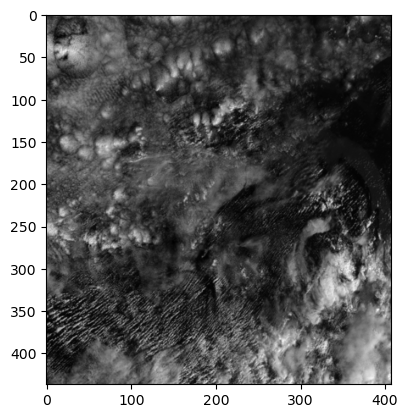

In [6]:
plt.imshow(C01['Rad'][:], cmap='gray')

## Basic Test

In [7]:
def basicTest(band, band_temp):
    return (band>0.03) & (band_temp<27)

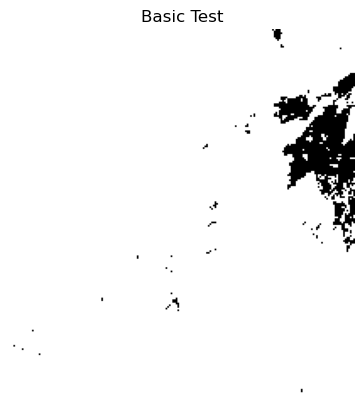

In [8]:
BasicT = basicTest(C06_Ref, Temp)
plt.title("Basic Test")
plt.axis('off')
plt.imshow(BasicT, cmap='gray')

### Sous-echantillonage

In [9]:
def sous_echantillonage(bande, r):
    return transform.downscale_local_mean(bande, r)
#1km de coté vers 2km
C01_Ref = sous_echantillonage(C01_Ref, (2,2))
C03_Ref = sous_echantillonage(C03_Ref, (2,2))
C05_Ref = sous_echantillonage(C05_Ref, (2,2))
#0.5km vers 2km
C02_Ref =  sous_echantillonage(C02_Ref, (4,4))
C05_Ref.shape

(219, 204)

### NDVI

In [10]:
def ndvi(band4, band3):
    return (band4-band3)/(band4+band3)

### Bande 4 = C03, Bande 3 = C02

In [11]:
NDVI = ndvi(C03_Ref, C02_Ref)

## MeanVis (Band1 + Band2 + Bnad3)/3
### Ici, pas d'équivalent Bande2 pour GOES-16 donc elle n'est pas prise en compte

In [12]:
def MeanVis(bande1, bande3):
    return (bande1 + bande3)/2

## Whiteness Test

In [13]:
def whiteness(bande1, bande3):
    return (np.absolute((bande1 - MeanVis(bande1, bande3))/MeanVis(bande1,bande3)) + np.absolute((bande3 - MeanVis(bande1,bande3))/MeanVis(bande1,bande3)))

In [14]:
Whiteness = whiteness(C01_Ref, C02_Ref)
WhitenessTest = Whiteness < 0.7

## HOT Test

In [15]:
def hotTest(bande1, bande3):
    return (bande1-0.5*bande3-0.08) > 0

In [16]:
HotT = hotTest(C01_Ref, C02_Ref)

## B4/B5 Test
### Bande4 = C03, Bande = C05

In [17]:
def b4_b5_test(bande4, bande5):
    return (bande4/bande5) > 0.75

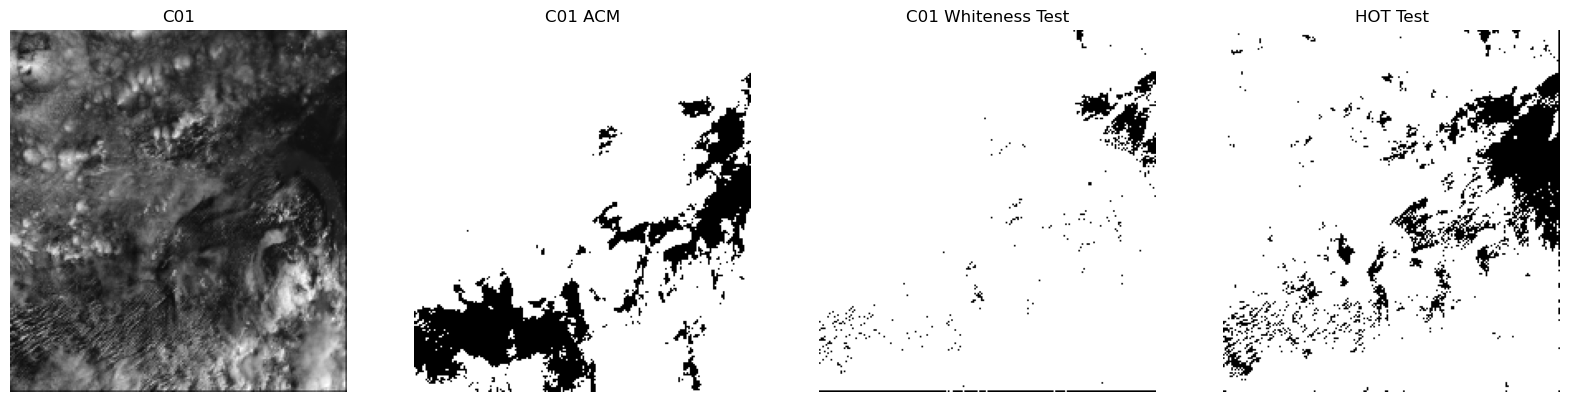

In [18]:
C01_ACM['BCM'][:]
fig = plt.figure(figsize=(20,7))

fig.add_subplot(1, 4, 1)
plt.title('C01')
plt.axis('off')
plt.imshow(C01_Ref, cmap='gray')

fig.add_subplot(1, 4, 2)
plt.title('C01 ACM')
plt.axis('off')
plt.imshow(C01_ACM['BCM'][:], cmap='gray')

fig.add_subplot(1, 4, 3)
plt.title('C01 Whiteness Test')
plt.axis('off')
plt.imshow(WhitenessTest, cmap='gray')

fig.add_subplot(1, 4, 4)
plt.title('HOT Test')
plt.axis('off')
plt.imshow(HotT, cmap='gray')



In [19]:
B4_B5_T = b4_b5_test(C03_Ref, C05_Ref)

## Water Test

In [20]:
def waterTest(ndvi, bande4):
    return (ndvi < 0.01) & (bande4 < 0.11) | (ndvi < 0.01) & (bande4 < 0.05)

In [21]:
WaterT = waterTest(NDVI, C03_Ref)
WaterT

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### Le test B4/B5, est totalement noir car aucune roche pouvant être confodue avec un nuage n'est présente sur l'image. En renvanche, on peut apercevoir un peu d'eau en haut à droite.

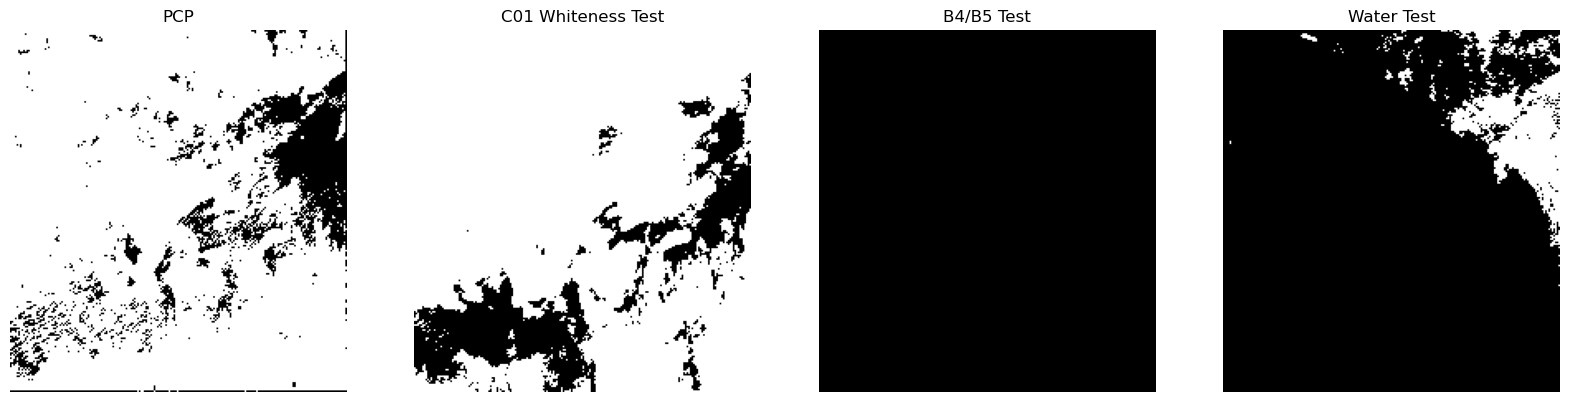

In [22]:
def func_pcp(BTest, WTest, HTest, B_Test):
    return (BTest==True) & (WTest==True) & (HTest==True) & (BTest==True)
    
PCP = func_pcp(BasicT, WhitenessTest, HotT, B4_B5_T)

fig = plt.figure(figsize=(20,7))
fig.add_subplot(1, 4, 1)
plt.title('PCP')
plt.axis('off')
plt.imshow(PCP, cmap='gray')

fig.add_subplot(1, 4, 2)
plt.title('C01 Whiteness Test')
plt.axis('off')
plt.imshow(C01_ACM['BCM'][:], cmap='gray')

fig.add_subplot(1, 4, 3)
plt.title('B4/B5 Test')
plt.axis('off')
plt.imshow(B4_B5_T, cmap='gray')

fig.add_subplot(1, 4, 4)
plt.title('Water Test')
plt.axis('off')
plt.imshow(WaterT, cmap='gray')

## Clear - Sky Water
### On peut voir qu'une partie de ce qui était clair sur le Water Test a été exclu. Cela n'est pas surprenant car des parties du Whiteness Test en blanc sont superposées avec le Water Test et sont donc éliminées.

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


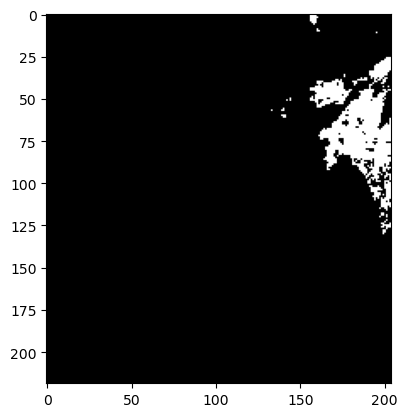

In [23]:
def clear_sky_water(WTest, band7):
    return (WTest==True) & (band7 < 0.03)
Clear_SkyWater = clear_sky_water(WaterT, C06_Ref)
print(Clear_SkyWater)
plt.imshow(Clear_SkyWater, cmap='gray')

## Twater 
### On récupère les valeurs de la Bande 6 (C14) là où les valeurs du Clear - Sky Water sont vraies. On prend le 82.5 centile de cette matrice.

In [1]:
def t_water(T, C_Sky_W):
    
    if C_Sky_W.sum() == 0:
        return 0
    else:
        return np.percentile(T[C_Sky_W], 82.5)
    
Twater = t_water(Temp, Clear_SkyWater)
Twater

In [25]:
def w_temp_prob(TWat, T):
    return (TWat-T)/4
wTemperature_Prob  = w_temp_prob(Twater, Temp)

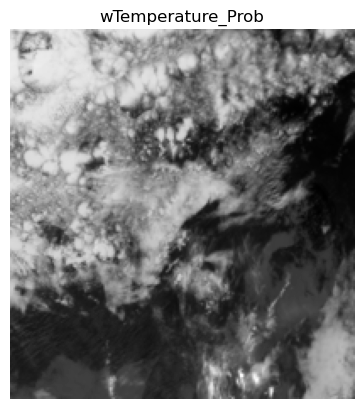

In [26]:
plt.title("wTemperature_Prob")
plt.axis('off')
plt.imshow(wTemperature_Prob, cmap='gray')

## Brightness Probabibilty

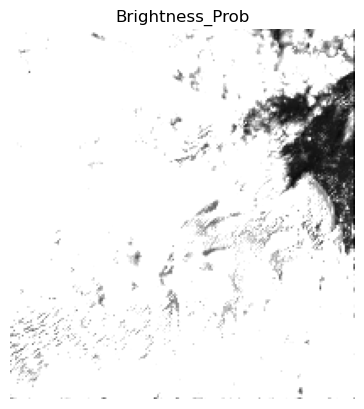

In [27]:
def brightnessProb(band5):
    res = np.zeros(band5.shape)
    for i in range(len(band5)):
        for j in range(len(band5[0])):
            res[i,j] = min(band5[i,j], 0.11)
    return res/0.11
            
Brightness_Prob = brightnessProb(C05_Ref)
plt.title("Brightness_Prob")
plt.axis('off')
plt.imshow(Brightness_Prob, cmap='gray')

## wCloud_Prob

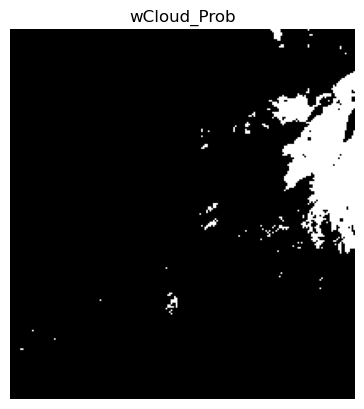

In [28]:
def w_cloud_prob(wTemp, bProb):
    return wTemp*bProb
w_Cloud_Prob = w_cloud_prob(wTemperature_Prob, Brightness_Prob)
plt.title('wCloud_Prob')
plt.axis('off')
plt.imshow(w_Cloud_Prob<0.5, cmap='gray')

## Clear - Sky Land

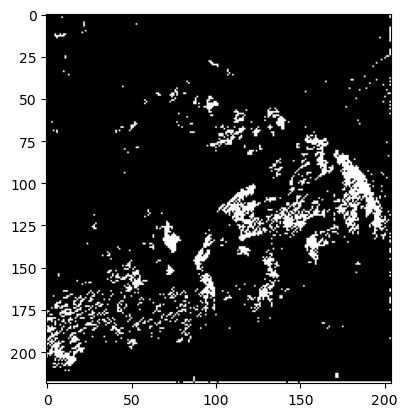

In [29]:
def clear_sky_land(P, Wat):
    return (P==False) & (Wat==False)
    
Clear_SkyLand = clear_sky_land(PCP, WaterT)
plt.imshow(Clear_SkyLand, cmap='gray')

## T low, T high

In [30]:
def t_high_low(T, CSL):
    return (np.percentile(T[CSL], 17.5), np.percentile(T[CSL], 82.5))
    
T_low, T_high = t_high_low(Temp, Clear_SkyLand)
print(T_low, T_high)

10.919315338134766 18.079315185546875


## LTemperature_Prob

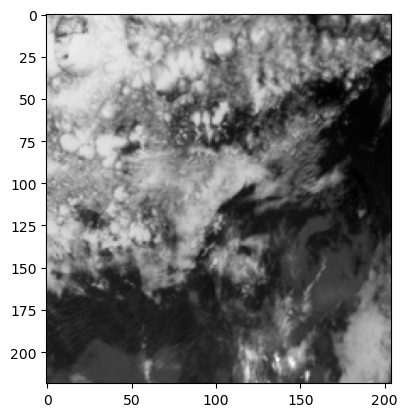

In [31]:
def l_temp_prob(T, T_h, T_l):
    return (T_h+4-T)/(T_h+4-(T_l-4))

LTemperature_Prob = l_temp_prob(Temp, T_high, T_low)
plt.imshow(LTemperature_Prob, cmap='gray')

## Variability_Prob


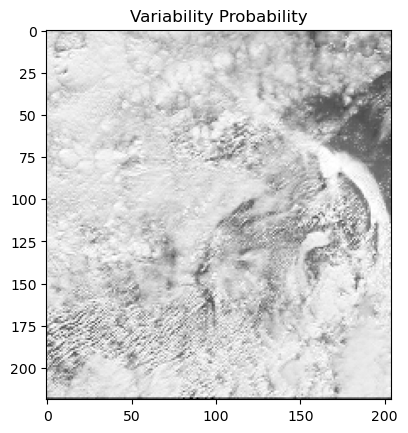

In [32]:
#Variability_Prob = 1-np.max(np.absolute(NDVI), WhitenessT)
#max reflectance max_radiance*kappa
#min reflectance min_radiance*kappa
def variability_Prob(band3,band4, ndvi, white):
    k = band3['kappa0']
    mini, maxi= band3['Rad'].valid_range[0]*k, band3['Rad'].valid_range[1]*k
    band3 = sous_echantillonage(reflectance(band3), (4,4))
    band4 = sous_echantillonage(reflectance(band4), (2,2))
    res = ((band3<mini) & (band3>maxi)) < band4
    for i in range(ndvi.shape[0]):
        for j in range(ndvi.shape[1]):
            if res[i,j] == True:
                ndvi[i,j] = 0
        
    return 1-np.maximum(ndvi, white)

var_Prob = variability_Prob(C02, C03, NDVI, Whiteness)
plt.title('Variability Probability')
plt.imshow(var_Prob, cmap='gray')

[[2.2714033126831055 1.9375410079956055 1.944588541984558 ...
  0.6857291460037231 0.6751388311386108 0.700038731098175]
 [2.1931517124176025 1.884229063987732 1.62907874584198 ...
  0.6800985336303711 0.5925155282020569 0.43208032846450806]
 [2.1853954792022705 2.005035400390625 1.796525239944458 ...
  0.7466637492179871 0.5245131850242615 0.4339660108089447]
 ...
 [0.3459278345108032 0.4904477000236511 0.5321775078773499 ...
  1.6739037036895752 1.3107287883758545 1.1292226314544678]
 [0.5434433817863464 0.5537941455841064 0.5874365568161011 ...
  1.650949239730835 1.2747595310211182 0.9151970744132996]
 [0.15511366724967957 0.08990863710641861 0.1787673830986023 ...
  0.34263283014297485 0.1577434241771698 0.17507041990756989]]


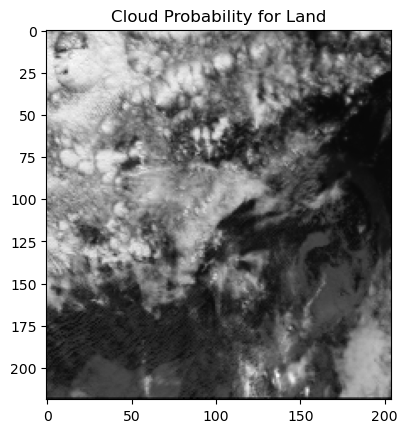

In [33]:
def land_cloud_prob(LT_prob, v_Prob):
    return LT_prob*v_Prob

LCloud_Prob = land_cloud_prob(LTemperature_Prob, var_Prob)
print(LCloud_Prob)
plt.title("Cloud Probability for Land")
plt.imshow(LCloud_Prob, cmap='gray')

In [34]:
def land_threshold(LC_prob, CSL):
    return np.percentile(LC_prob[CSL], 82.5)+0.2
    
L_threshold = land_threshold(LCloud_Prob, Clear_SkyLand)
L_threshold

0.6111663699150085

29379


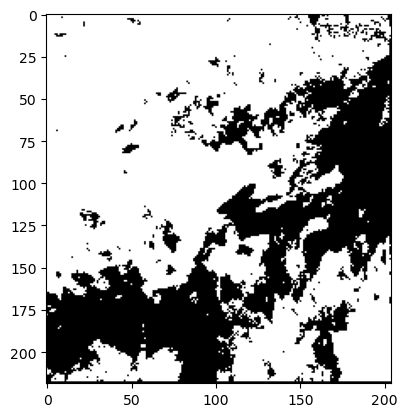

In [35]:
def pot_cloud_layer(pcp, wT, wC_prob, LC_prob, LT, T, Tl):
    return (pcp & (wT==True) & (wC_prob>0.5)) | ((pcp==True) & (wT == False) & (LC_prob>LT)) | ((LC_prob>0.99) & (wT==False)) | (T<(Tl-35))
Pot_Cloud_Layer = pot_cloud_layer(PCP, WaterT, w_Cloud_Prob, LCloud_Prob, L_threshold, Temp, T_low )#(PCP & (WaterT==True) & (w_Cloud_Prob>0.5)) | ((PCP==True) & (WaterT == False) & (LCloud_Prob>L_threshold)) | ((LCloud_Prob>0.99) & (WaterT==False)) | (Temp<(T_low-35))

plt.imshow(Pot_Cloud_Layer, cmap='gray')
print(Pot_Cloud_Layer.sum())

## Compter les pixels comme nuage dans un voisinage 3x3

44676

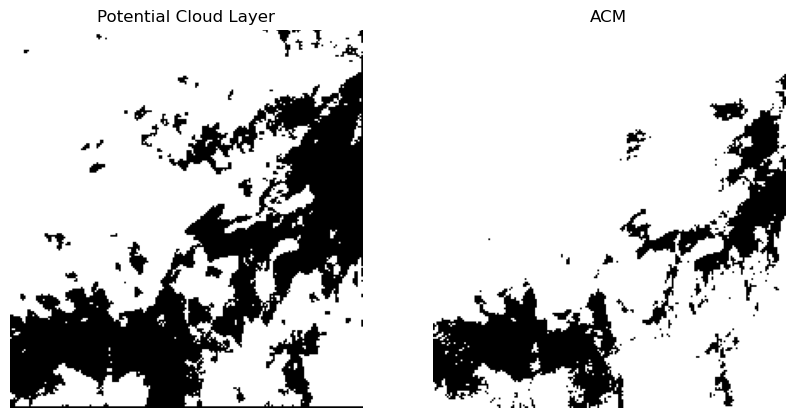

In [36]:
def setCloud(M):
    count = 0
    for i in range(1, M.shape[0]-1):
        for j in range(1, M.shape[1]-1):
            #verifie voisinnage 
            count = M[i-1, j-1: j+1].sum() + M[i,j-1].sum()+M[i, j+1].sum() + M[i+1, j-1:j+1].sum()
            if count >= 5: M[i][j] = True
            count = 0
    return M
            
setCloud(Pot_Cloud_Layer)
fig= plt.figure(figsize=(10,7))
fig.add_subplot(1,2,1)
plt.title("Potential Cloud Layer")
plt.axis('off')
plt.imshow(Pot_Cloud_Layer, cmap='gray')
fig.add_subplot(1,2,2)
plt.title('ACM')
plt.axis('off')
plt.imshow(C01_ACM['BCM'][:], cmap='gray')

Pot_Cloud_Layer.size

## Comparaison avec ACM

In [37]:
def confusion(prediction, acm):
    vrai_pos, faux_pos= 0, 0
    vrai_neg, faux_neg = 0, 0
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            #vrais positifs
            #print("prediction : ", prediction[i,j])
            if ((prediction[i,j]) & (acm[i,j])):
                vrai_pos += 1
            #vrai negatif
            elif ((~prediction[i,j]) & (~acm[i,j])):
                vrai_neg += 1
            #faux positifs
            elif ((prediction[i,j]) & (~acm[i,j])):
                faux_pos += 1
            #faux negatif
            else:
                faux_neg += 1
                
    neg_ACM = (faux_pos+vrai_neg)/(~acm).sum()
    total = prediction.size
    #retourne les valeurs de confusion pour la prediction puis pour l'acm
    #print("accuracy : ", )
    acc = (vrai_pos+vrai_neg)/acm.size
    #print(np.logical_not(acm).sum(), prediction.sum())
    conf_prediction = (vrai_pos/prediction.sum(), faux_pos/prediction.sum(), faux_neg/np.logical_not(prediction).sum(), vrai_neg/np.logical_not(prediction).sum())
    conf_acm = ((vrai_pos)/acm.sum(), (faux_pos)/np.logical_not(acm).sum(), (faux_neg)/acm.sum(), (vrai_neg)/np.logical_not(acm).sum())
    return conf_prediction, conf_acm, acc
    #print(f"vrai positifs: {vrai_pos/total}, faux positifs: {faux_pos/total}, vrai negatifs: {vrai_neg/total}, faux negatifs: {faux_neg/total}")
    #print(f"""Prediction: vrai positifs: {vrai_pos/prediction.sum()}, faux positifs: {faux_pos/prediction.sum()}, faux negatifs: {faux_neg/(~prediction).sum()}, vrai negatifs {vrai_neg/(~prediction).sum()}\n
    #ACM:  vrai positifs: {(vrai_pos)/acm.sum()}, faux negatifs: {(faux_pos+vrai_neg)/acm.sum()}, faux positifs: {faux_pos/(~acm).sum()}, vrai negatif: {vrai_neg/(~acm).sum()}""")           

confusion(Pot_Cloud_Layer, C01_ACM['BCM'][:])
#C01_ACM['BCM'][:]

((0.9878310425745893,
  0.012168957425410661,
  0.5044456419237505,
  0.4955543580762495),
 (0.7973536096980193,
  0.04702072538860104,
  0.20264639030198073,
  0.952979274611399),
 0.8242456800071627)

## Automatisation
### Test des algos sur toutes les images du mois de janvier

In [38]:
from datetime import time

def hour_rad(R): #renvoie heures et minutes
    rad_t = time(hour = int(R[84:86]), minute = int(R[86:88]), second = int(R[88:90]))
    return rad_t

def hour_acm(A):
        acm_t = time(hour = int(A[76:78]), minute = int(A[78:80]), second = int(A[80:82]))
        return acm_t
    
def comp_hour(R, A): #compare heure acm et rad
    rad_t = hour_rad(R)
    acm_t = hour_acm(A)
    return rad_t == acm_t



### Recuperation des fichiers

In [39]:
import glob

In [40]:
#from skimage.morphology import flood_fill
rad_path = "D:\\Images_Projet_Teledetection\\Rad\\"
#res = netCDF4.Dataset(rad_path, 'r')
#On a seulement besoin de C 1,2,3,5,6,14
def path_to_file(path):
    bands = [1,2,3,5,6,14]
    f= []
    for jour in range(1,32):
        #traverse chaque bande    
        for band in bands:
            f.append(glob.glob(path+"C{:02d}".format(band)+"\\2022_{:03d}".format(jour)+"\\OR_ABI-L1b-RadReg-M6C*{:02d}".format(band)+"*"))
    return f

acm_path = "D:\\Images_Projet_Teledetection\\ACM\\"
def path_to_acm(path, ndays=1):
    f = []
    for jour in range(1, ndays+1):
        f.append(glob.glob(path + "2022_{:03d}".format(jour)+"\\OR_ABI-L2-ACMReg-M6_G16_"+"*"))
    return f
  
    
#Les 6 premieres rangees du tableau sont les bandes dans l'ordre pour chaque jour. Et cela continue pour le reste.
res = path_to_file(rad_path)
res1 = path_to_acm(acm_path, 31)

In [47]:
#version obsolete programme rangement fichiers
def file_sort(files):
    C01_H,C02_H,C03_H, C05_H, C06_H, C14_H = [], [], [], [], [], []
    
    for i in range(0, len(files), 6):
        C01_H.append(files[i])
        C02_H.append(files[i+1])
        C03_H.append(files[i+2])
        C05_H.append(files[i+3])
        C06_H.append(files[i+4])
        C14_H.append(files[i+5])
    return C01_H,C02_H,C03_H, C05_H, C06_H, C14_H

#cette fonction suppose que si on a le meme nombre d'heures pour toutes les bandes, aucune ne manque
def file_sort2(files):
    bands = [1,2,3,5,6,14]
    C_H = [[], [], [], [], [], []]
    #acm_res = [[] for i in range(len(acm))] #
    #trouve le jour avec le plus de mesures et le prend comme reference
    nb_mesure = len(max(files, key=len))
    #print("max : ", nb_mesure)
    #parcours les fichiers
    for i in range(0, len(files), 6):
        #stocke le nombre de mesures au i-eme jour pour les 6 bandes
        len_list = [len(files[i]), len(files[i+1]), len(files[i+2]),len(files[i+3]),len(files[i+4]),len(files[i+5])]
        #comportement de base : aucune mesure ne manque, on ajoute
        if sum(len_list) == len(len_list)*nb_mesure:
            C_H[0].append(files[i]) #C01
            C_H[1].append(files[i+1]) #C02
            C_H[2].append(files[i+2]) #C03
            C_H[3].append(files[i+3]) #C05
            C_H[4].append(files[i+4]) #C06
            C_H[5].append(files[i+5]) #C14
        #il manque au moins une mesure on fait une recherche manuelle   
        else:
            min_list = min(len_list)
            min_pos = len_list.index(min_list)
            comp_list = files[i:(i+5)+1]#files[i:i+min_pos] + files[i+min_pos+1:] #toutes les bandes du jour sauf celle du plus petit
            #parcours la bande avec le moins d'heures car on aura au maximum son nombre d'heures desormais
            n = [[] for band in comp_list]
            for j in range(len_list[min_pos]):
                #chaque bande est parcourue jusqu'a trouver l'heure si elle existe
                for k in range(len(comp_list)):
                    added = False
                    #parcours individuellement la bande
                    for f in comp_list[k]:
                        if hour_rad(f) == hour_rad(files[i+min_pos][j]):
                            n[k].append(f) 
                            added = True
                            continue
                        #pour accelerer programme, ajouter un if hour_rad(f) > hour_rad(files[i+min_pos][j]) 
                        #et sortir de la boucle en considerant que l'heure ne se trouve pas plus loin (supposition : les horaires sont dans l'ordre grace a glob)
                    if not added:
                        n[k]+=[0]#aucune date ne correspond
                #verification ACM
                """for f in acm[i//len(len_list)]:
                    added = False
                    if hour_acm(f) == hour_rad(files[i+min_pos][j]):
                        acm_res[i//len(len_list)].append(f)
                        added=True
                #if not added:
                    #acm_res[i//len(len_list)]+=[0]"""
                        
            #print(len(n[1]))
            #ajoute les bandes a la variable de sortie respective
            c = 0
            #print(n)
            for l in range(len(C_H)):
                C_H[l].append(n[l])
                    
    return C_H#, acm_res
        
r = file_sort(res)
m = file_sort2(res)


In [48]:
len(m[0][13]) #[bande][jour][horaire]
#len(res1[13]) #[jour][horaire]


77

In [49]:
C = m[0][0][0]
D = res1[0][0]
print(C, D)
print(comp_hour(C, D))
a = time(hour = 11 , minute = 35, second = 45)
b = time(hour = 12 , minute = 34, second = 45)
a<b

D:\Images_Projet_Teledetection\Rad\C01\2022_001\OR_ABI-L1b-RadReg-M6C01_G16_s20220010900207_e20220010909515_c20220010909560.nc D:\Images_Projet_Teledetection\ACM\2022_001\OR_ABI-L2-ACMReg-M6_G16_s20220010900207_e20220010909515_c20220010911343.nc
True


True

In [50]:

"""for i in range(len(r[0])):
    if not len(r[0][i]) == len(res1[i]):
        print(i, len(r[0][i]) == len(res1[i]))"""
len(r[3][6])
#plt.imshow(netCDF4.Dataset('D:\\Images_Projet_Teledetection\\Rad\\C01\\2022_007\\OR_ABI-L1b-RadReg-M6C01_G16_s20220071530210_e20220071539518_c20220071539567.nc', 'r')['Rad'][:], cmap='gray')

78

## Fonction compare les heures du fichier Rad et ACM

## Utilisation de FMask sur tous les fichiers.
### Chaque bande est parcourue en même temps selon le jour. Il y a autant de fichier pour la même journée dans l'ACM que dans Rad. La seule exception est pour le 14eme jour, c'est pour cette raison qu'une vérification a été ajoutée si on décide de l'appliquer à d'autres dossiers.

In [2]:
"""Equivalences :
band1 C01
band2 x
band3 C02
band4 C03
band5 C05
band6 C14
band7 C06
""" 

def FMask(path, path_acm):
    F = path_to_file(path)
    days = file_sort2(F)
    ACM = path_to_acm(path_acm, len(days[0]))
    count = [0 for i in range(6)]
    #prob_res = []
    #Parcours des 31 jours du mois
    for i in range(0, len(days[0])):
        #Parcours des heures du jour
        print(len(days[0][i]))
        #ACM ou la bande peut etre plus petit donc on s'assure de le prendre pour ne pas depasser
        for j in range(0, min(len(days[0][i]), len(ACM[i]))):
            #verifie que ce les heures sont les memes pour le fichier acm et rad sinon on ignore ce jour 
            N = comp_hour(days[0][i][j], ACM[i][j]) and comp_hour(days[1][i][j], ACM[i][j]) and comp_hour(days[2][i][j], ACM[i][j]) and comp_hour(days[3][i][j], ACM[i][j]) and comp_hour(days[4][i][j], ACM[i][j]) and comp_hour(days[5][i][j], ACM[i][j])
            if N and i <= 0:
                #Recuperation des bandes et ACM
                Acm = netCDF4.Dataset(ACM[i][j], 'r')['BCM'][:]
                C01_Rad = netCDF4.Dataset(days[0][i][j], 'r')
                C02_Rad = netCDF4.Dataset(days[1][i][j], 'r')
                C03_Rad = netCDF4.Dataset(days[2][i][j], 'r')
                C05_Rad = netCDF4.Dataset(days[3][i][j], 'r')
                C06_Rad = netCDF4.Dataset(days[4][i][j], 'r')
                C14 = netCDF4.Dataset(days[5][i][j], 'r')

                #conversion de la radiance en reflectance
                C01  = reflectance(C01_Rad)
                C02  = reflectance(C02_Rad)
                C03  = reflectance(C03_Rad)
                C05  = reflectance(C05_Rad)
                C06  = reflectance(C06_Rad)
                #Conversion bande 6 en temperature
                Temp = band_to_temp(C14) - 273.15
                #prend la bande 7 et bande temperature en parametre
                BasicT = basicTest(C06, Temp)
                #sous-echantillonage, on ignore C06 car elle est deja a la bonne taille et C14 car elle on ne va utiliser que la bande Temp 
                C01 = sous_echantillonage(C01, (2,2))
                C02 = sous_echantillonage(C02, (4,4))
                C03 = sous_echantillonage(C03, (2,2))
                C05 = sous_echantillonage(C05, (2,2))
                #Calcul du NDVI
                NDVI = ndvi(C03, C02)
                #Matrice de blancheur
                White = whiteness(C01, C02)
                #Test de blancheur
                WhiteT = White < 0.7
                HotT = hotTest(C01, C02)
                B4B5 = b4_b5_test(C03, C05)
                WaterT = waterTest(NDVI, C03)
                PCP = func_pcp(BasicT, WhiteT, HotT, B4B5)
                #Clear sky water prend water test bande 7
                CSK = clear_sky_water(WaterT, C06)
                #Temperature de l'eau
                Twater = t_water(Temp, CSK)
                WTempProb = w_temp_prob(Twater, Temp)
                BrightP = brightnessProb(C05)
                WCloudP = w_cloud_prob(WTempProb, BrightP)
                CSL = clear_sky_land(PCP, WaterT)
                THighLow = t_high_low(Temp, CSL)
                LandTempProb = l_temp_prob(Temp, THighLow[0], THighLow[1])
                VarProb = variability_Prob(C02_Rad,C03_Rad, NDVI, White)
                LCloudProb = land_cloud_prob(LandTempProb, VarProb)
                LandT = land_threshold(LCloudProb, CSL)
                PCloudL = pot_cloud_layer(PCP, WaterT, w_Cloud_Prob, WCloudP, LandT, Temp, THighLow[0] )
                PCloudL = setCloud(PCloudL)
                print(f"jour {i+1}, capture {j}")
                #if i == 0:
                    #prob_res.append(confusion(PCloudL, Acm))
                confusion(PCloudL, Acm)
    #return prob_res
                
#J1 = 
FMask(rad_path, acm_path)

In [56]:
accuracy = []
for acc in J1:
    accuracy.append(acc[-1])


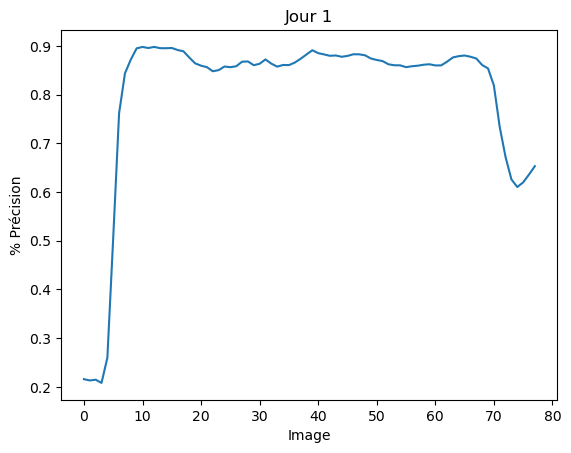

In [58]:
plt.plot([i for i in range(len(accuracy))], accuracy)
plt.ylabel("% Précision")
plt.title("Jour 1")
plt.xlabel("Image")
plt.show()

In [60]:
sum(accuracy)/len(accuracy)

0.8030354162505652